<p style="text-align:center;font-size:200%;"><b>BOT Detection on Twitter</b></p>
<p style="text-align:center;font-size:150%;"><b>fine-tuning BERT</b></p>

# Requirement

In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm 
import numpy as np
import os
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
import random
import matplotlib.pyplot as plt
# loading custome packages
os.chdir('..')
from twitterED.utilities.utils import get_length , tokenizer, encoding_data, text_cleaning
from twitterED.network.model import BERT
from twitterED.utilities.metrics import f1_score_func, accuracy_per_class,evaluate

# Data

## preparation

In [2]:
# loading dataset
df = pd.read_csv('./data/raw/tweet_df.csv',header=0)
df = df[['tweet','account_type']] # selecting required columns
df.head()

,tweet,account_type
0,UB40 - Red Red Wine,bot
1,@kartierbello Dawg I’m fucking sick of myself 😭,human
2,"@Garratt_J Well spotted, they are actually the...",human
3,@r_j17 @BurnleyOfficial Pretty much like most ...,human
4,@Sidlotte1 The first few minutes are an eye op...,human


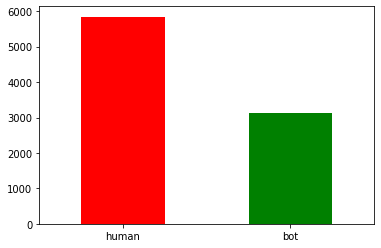

In [3]:
# plotting count account type
ax =df['account_type'].value_counts().plot.bar(x='lab', y='val', rot=0,color = list('rgbkymc'))

In [4]:
#cleaning text

# fixing contarctions
df['tweet']= df['tweet'].apply(text_cleaning.fix_contractions)

# remove accent characters
df['tweet']= df['tweet'].apply(text_cleaning.remove_accented_chars)

# remove digits
df['tweet']= df['tweet'].apply(text_cleaning.remove_digits)

#remove excess withe spaces
df['tweet']= df['tweet'].apply(text_cleaning.remove_excess_whitespace)

# remove punctuations except ?!
df['tweet']= df['tweet'].apply(text_cleaning.rm_punctuation1)

# teurn to lower case
df['tweet']= df['tweet'].apply(text_cleaning.lower)


In [5]:
# check whether cleaning data has left any null value
df.isnull().sum()

tweet           0
account_type    0
dtype: int64

In [6]:
# sample of data after cleaning
df.sample(10)

,tweet,account_type
5982,davidvick5 moorsy11 not sure quite what home...,human
7913,yeovil westfield\n4h current weather wind c...,bot
4263,clairevbishop thank you,human
5494,fplpokerplayer eighty one phenomenal well...,human
3966,bon jovi it is my life,bot
1061,mkues65 washingtonpost how are teachers unio...,human
2069,jainsudhir i have found these solutions work ...,bot
8020,wham i am your man,bot
5769,i was literally just talking about this to my ...,human
530,zero_ughclock people can not do that https ...,human


In [7]:
# converting classes to integer
possible_labels = df['account_type'].unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'bot': 0, 'human': 1}

In [8]:
#Adding a new column to our original data-frame, of numbers corresponding to each emotion label
df['label'] = [label_dict[str_label] for str_label in df['account_type']]
df.head()

,tweet,account_type,label
0,ub40 red red wine,bot,0
1,kartierbello dawg i am fucking sick of myself,human,1
2,garratt_j well spotted they are actually the...,human,1
3,r_j17 burnleyofficial pretty much like most ...,human,1
4,sidlotte1 the first few minutes are an eye op...,human,1


In [9]:
# splitting dataset into train,Validation and test
split = .2 # rate to split data to test and train_validation
test_idx = int(df.shape[0]-df.shape[0]*.2) # index for splitting
df_tst = df.iloc[test_idx:,:] # test dataset
df_trval = df.iloc[:test_idx,:] # train and validation dataset
df.shape,df_trval.shape,df_tst.shape

((8967, 3), (7173, 3), (1794, 3))

In [10]:
## Splitting df_trval to train and vallidation sets
x_train, x_val, y_train, y_val = train_test_split(
    df_trval.index.values,
    df_trval['label'],
    test_size = 0.15, #let's do 85-15 train-validation split
    random_state=17, #reproducible between my instance and whoever wants to reproduce
    stratify= df_trval['label'].values
)

C:\Users\ehsan\.conda\envs\emodetection\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ehsan\.conda\envs\emodetection\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


<AxesSubplot:xlabel='label'>

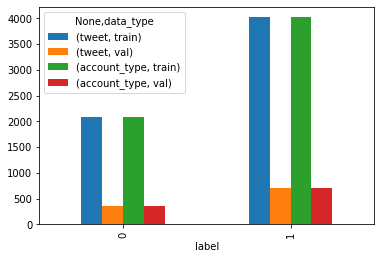

In [11]:
# adding a dummy column as data type
df_trval['data_type'] = ['not_set']*df_trval.shape[0]
df_trval.loc[x_train, 'data_type'] = 'train'
df_trval.loc[x_val, 'data_type'] = 'val'
df_g = df_trval.groupby(['label', 'data_type']).count()
df_g.unstack().plot(kind='bar')

## tokenasation using bert tokeniser

In [12]:
#getting the maximum lenth of tweets for padding tokens
max_len = max(df_trval['tweet'].apply(get_length))
print (f'maximum length of tweet:{max_len}')

maximum length of tweet:57


In [13]:
# encoding data using bert tokeniser
## encoding train data
train_data = df_trval[df_trval['data_type']=='train'].tweet.values
encoded_data_train = encoding_data(train_data, max_len = max_len)
#encoding process above returns dictionaries. We grab input ID tokens, attention mask, and labels from this
input_ids_train = encoded_data_train['input_ids'] #return each sentence as a #
attention_masks_train = encoded_data_train['attention_mask'] #returns a pytorch tensor
labels_train = torch.tensor(df_trval[df_trval.data_type=='train'].label.values)

## encoding validation data
val_data = df_trval[df_trval['data_type']=='val'].tweet.values
encoded_data_val = encoding_data(val_data, max_len = max_len)
input_ids_val = encoded_data_val['input_ids'] #return each sentence as a #
attention_masks_val = encoded_data_val['attention_mask'] #returns a pytorch tensor
labels_val = torch.tensor(df_trval[df_trval.data_type=='val'].label.values)

C:\Users\ehsan\.conda\envs\emodetection\lib\site-packages\transformers\tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [14]:
# using pytorch to bulid train and validation datasets
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_validation = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train),len(dataset_validation)

(6097, 1076)

# Training

## loading model and setting requried parameters

In [15]:
# loading the pretrained BERT
model = BERT(label_dict=label_dict)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [16]:
# print the loded model
params = list(model.named_parameters())
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [17]:
# building data loaders
batch_size = 16

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train), #randomise dataset during training
    batch_size=batch_size
)

#batch size of 32 fine because not computationally exhaustive to validate. No backprop for e.g.
dataloader_val = DataLoader(
    dataset_validation,
    sampler=RandomSampler(dataset_validation), #randomise dataset during training
    batch_size=batch_size
)

In [18]:
# optimiser and other parameters
optimizer = AdamW(
    model.parameters(),
    lr=1e-5, #2e-5 > 5e-5: A HYPERPARAMETER
    eps=1e-8
)

#controls learning rate
epochs=5 

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

## training

In [19]:
# feeding cuda randomly
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val) #useful for using a GPU

In [20]:
#to check GPU vs CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [21]:
Ltr_hist =[]
Lval_hist = []
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    
    #set to 0 initially, then add each batch's loss iteratively
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='./wieght/botdtc/Epoch {:1d}'.format(epoch),
                        leave=False, #let it overwrite after each epoch
                        disable=False, 
                       )
    for batch in progress_bar:
        
        #first batch = set gradients to 0
        model.zero_grad()
        
        #dataloader has 3 variables. so it's going to be a tuple of 3 items. making sure each item is on correct device
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids' : batch[0],
            'attention_mask' : batch[1],
            'labels' : batch[2]
        }
        
        #unpacks dictionary straight into model
        outputs = model(**inputs)
        
        #bert model returns loss and logits
        loss = outputs[0]
        loss_train_total += loss.item() #add up loss
        loss.backward() #backpropagate
        
        #all weights will be a norm of 1 (normalised weights)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        #update progress bar to display loss per batch
        progress_bar.set_postfix({'training_loss' : '{:3f}'.format(loss.item()/len(batch))})
        
    #outside the batch loop and inside the epoch loop, so per epoch
    #save model checkpoint and print progress
    torch.save(model.state_dict(), f'./wieght/botdtc/Epoch-{epoch}.model')
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    Ltr_hist.append(loss_train_avg)
    #loss per epoch:
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    #to detect overtraining - happens when training loss goes down and val loss goes up. Starts to
    #train perfectly on our data such that its no longer generalisable
    #does exactly 
    val_loss, predictions, true_vals = evaluate(dataloader_val,model = model, device=device) #predictions are the logits
    Lval_hist.append(val_loss)
    


    #_labels, _preds = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    #tqdm.write(f'F1 Score (weighted): {val_f1}')
    _labels, _preds = f1_score_func(predictions, true_vals)


Epoch 1
Training loss: 0.1280399144719189



Validation loss: 0.05692254039390451



Epoch 2
Training loss: 0.03243821628433798



Validation loss: 0.04420717548226308



Epoch 3
Training loss: 0.015488320068366026



Validation loss: 0.04307263346109882



Epoch 4
Training loss: 0.00640562846374403



Validation loss: 0.04989203302252195



Epoch 5
Training loss: 0.003362653798678785



Validation loss: 0.04998332228120382



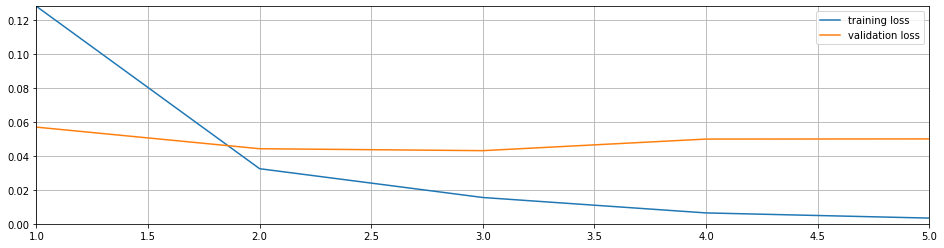

In [22]:
# plotting the training performance
%matplotlib inline
_,ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(1+np.arange(len(Ltr_hist)),Ltr_hist)
ax.plot(1+np.arange(len(Lval_hist)),Lval_hist)
ax.grid('on')
ax.set_xlim(left=1, right=len(Ltr_hist))
ax.set_ylim(bottom =0, top = max(Ltr_hist))
ax.legend(['training loss', 'validation loss'])

## evaluation

In [28]:
model.to(device)
pass #so we dont have all that text printed out

In [29]:
#trained model on GPU, putting it back to CPU
model.load_state_dict(
    torch.load('./wieght/botdtc/Epoch-2.model',
              map_location=torch.device('cpu')))

<All keys matched successfully>

In [30]:
#evaluating model, not caring about loss anymore which is 1st argument
_, predictions, _true_vals = evaluate(dataloader_val,model,device=device)

In [31]:
# calculating accuracy of the model
accuracy_per_class(predictions, _true_vals,label_dict=label_dict)

Class: bot
Accuracy: 99.45
Class: human
Accuracy: 99.01


## Test model 

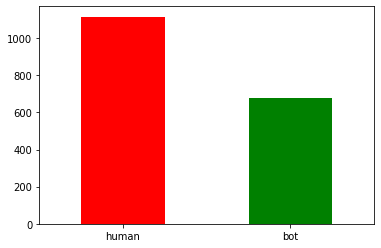

In [32]:
# plotting the cont of account type in test dataset
ax =df_tst['account_type'].value_counts().plot.bar(x='lab', y='val', rot=0,color = list('rgbkymc'))

In [34]:
# calculating maximum length of tweets for padding
max_len = max(df_tst['tweet'].apply(get_length))
print (f'maximum length of tweet:{max_len}')

maximum length of tweet:53


In [35]:
# tokenising data
test_data = df_tst.tweet.values
encoded_data_test = encoding_data(test_data, max_len = max_len)
#encoding process above returns dictionaries. We grab input ID tokens, attention mask, and labels from this
input_ids_test = encoded_data_test['input_ids'] #return each sentence as a #
attention_masks_test = encoded_data_test['attention_mask'] #returns a pytorch tensor
labels_test = torch.tensor(df_tst.label.values)

C:\Users\ehsan\.conda\envs\emodetection\lib\site-packages\transformers\tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [36]:
# dataset and dataloader
dataset_tst = TensorDataset(input_ids_test, attention_masks_test,labels_test)
dataloader_tst = DataLoader(dataset_tst,batch_size=16)

In [37]:
_, predictions, _true_vals = evaluate(dataloader_tst,model,device=device)

In [38]:
accuracy_per_class(predictions, _true_vals,label_dict=label_dict)

Class: bot
Accuracy: 98.97
Class: human
Accuracy: 98.30
